In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import keras

In [4]:
#Disables the GPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [6]:
#Prevent memory growth

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass   

## Data Loading Functions

In [7]:
import gdown

In [8]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [9]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
print(vocab, end = '')

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [15]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [17]:
#75 frames, 46 x 140 high, 1 channel
frames, alignments = load_data(tf.convert_to_tensor(test_path))

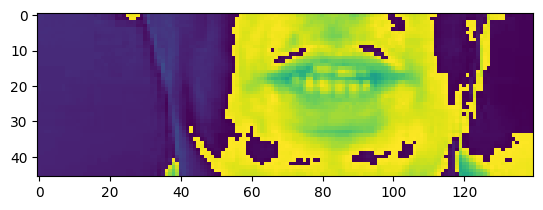

In [18]:
plt.imshow(frames[40])

In [19]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.19734783],
         [ 0.07893913]],

        [[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209044 ],
         [ 1.4209044 ],
         [ 1.3814349 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.946331  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.86739

In [20]:
#Number representation of what is said

alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Data Pipeline

In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [24]:
len(test)

50

In [25]:
frames, alignments = data.as_numpy_iterator().next()

In [26]:
len(frames)

2

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next(); val[0]

array([[[[[ 1.4013304 ],
          [ 1.4013304 ],
          [ 1.3612924 ],
          ...,
          [ 9.408932  ],
          [ 9.84935   ],
          [ 9.929426  ]],

         [[ 1.4013304 ],
          [ 1.4013304 ],
          [ 1.3612924 ],
          ...,
          [ 9.44897   ],
          [ 9.889388  ],
          [ 9.84935   ]],

         [[ 1.3212543 ],
          [ 1.3212543 ],
          [ 1.3212543 ],
          ...,
          [10.209692  ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.8808362 ],
          [ 0.8808362 ],
          [ 0.8808362 ],
          ...,
          [10.009502  ],
          [ 9.969464  ],
          [ 9.969464  ]],

         [[ 0.8808362 ],
          [ 0.8808362 ],
          [ 0.8808362 ],
          ...,
          [ 9.929426  ],
          [ 9.929426  ],
          [ 9.929426  ]],

         [[ 0.8808362 ],
          [ 0.8808362 ],
          [ 0.8808362 ],
          ...,
          [ 9.929426  ],
          [ 9.929426  ],
          

In [75]:
val[0][0].shape

(75, 46, 140, 1)

In [1]:
imageio.mimsave('./animation.gif', np.squeeze(val[0][0], axis = -1), fps=10)

NameError: name 'imageio' is not defined

In [79]:
np.squeeze(val[0][0], axis = -1).shape

(75, 46, 140)

In [34]:
alignments

array([[16, 12,  1,  3,  5, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39,  4,
        39, 19,  9, 24, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 18,  5,  4, 39,  1, 20, 39, 21, 39,  6, 15, 21,
        18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [ ]:
# val = test.next(); val[0]

In [ ]:
# print(val[0][1].shape, val[0][1].dtype)

In [ ]:
# imageio.mimsave('./animation.gif', np.squeeze(val[0][0]), fps = 10)

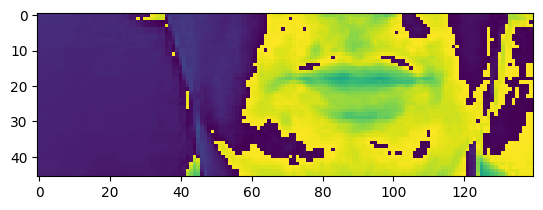

In [44]:
# 0: Videos, 0: 1st video out of the batch, 0: returns the first frame
plt.imshow(val[0][0][35])

In [45]:
tf.strings.reduce_join([num_to_char(word) for word in val [1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white at v one again'>

## Deep Neural Network

In [46]:
from keras.models import Sequential 
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [47]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [48]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

#Return Sequence allows output of all the words
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [50]:
yhat = model.predict(val[0])

1/1 [==============================] - 8s 8s/step


In [51]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx!'>

In [52]:
model.input_shape

(None, 75, 46, 140, 1)

In [53]:
model.output_shape

(None, 75, 41)

## Training the Model

In [45]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr 
    else:
        return lr * tf.math.exp(-0.1)

In [46]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [47]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [48]:
model.compile(optimizer = Adam(learning_rate = 0.00001), loss = CTCLoss)

In [49]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor = 'loss', save_weights_only = True)

In [50]:
schedule_callback = LearningRateScheduler(scheduler)

In [51]:
example_callback = ProduceExample(data)

In [52]:
model.fit(train, validation_data = test, epochs = 100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


1/1 [==============================] - 2s 2s/steps - loss: 107.01
Original: set red by h eight now
Prediction:  e e e e 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green by p six please
Prediction:  e e e e 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 682s 1s/step - loss: 107.0144 - val_loss: 80.7632 - lr: 1.0000e-05
Epoch 2/100
1/1 [==============================] - 0s 190ms/step
Original: lay white sp by l eight please
Prediction: e e e e e e 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red in v five soon
Prediction: e e e e e 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 406s 902ms/step - loss: 81.1291 - lr: 1.0000e-05
Epoch 3/100
1/1 [=========

## Testing the model

In [54]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [55]:
model.load_weights('models\checkpoint')

In [56]:
sample = val

In [57]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 232ms/step


In [58]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white at v one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y two now'>]

In [59]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [60]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white at v one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y two now'>]

## Prediction on a Video

In [61]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [62]:
print('~'*50, 'REAL TEXT', '~'*50)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [63]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [64]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [65]:
print('~'*50, 'PREDICTIONS', '~'*50)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]